In [5]:
import nfstream
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from tqdm import tqdm
import seaborn as sns

import joblib

1: src_port
2: dst_port
3: protocol
4: ip_version
5: vlan_id
6: tunnel_id
7: bidirectional_first_seen_ms
8: bidirectional_last_seen_ms
9: bidirectional_duration_ms
10: bidirectional_packets
11: bidirectional_bytes
12: src2dst_first_seen_ms
13: src2dst_last_seen_ms
14: src2dst_duration_ms
15: src2dst_packets
16: src2dst_bytes
17: dst2src_first_seen_ms
18: dst2src_last_seen_ms
19: dst2src_duration_ms
20: dst2src_packets
21: dst2src_bytes
22: application_name
23: application_category_name
24: user_agent
25: content_type

In [2]:
dataset_dir = 'ids-dataset'
benign_dir = os.path.join(dataset_dir, 'benign/')
malicious_dir = os.path.join(dataset_dir, 'malicious/')
benign_files = os.listdir(benign_dir)
malicious_files = os.listdir(malicious_dir)

def get_features_from_pacp_file(pcap_file):
	flow = nfstream.NFStreamer(source=pcap_file, statistical_analysis=False).to_pandas()
	# encode the application_name, application_category_name, user_agent, content_type
	flow['application_name'] = le.fit_transform(flow['application_name'])
	flow['application_category_name'] = le.fit_transform(flow['application_category_name'])
	flow['user_agent'] = le.fit_transform(flow['user_agent'])
	flow['content_type'] = le.fit_transform(flow['content_type'])
	# drop the columns which are not required
	flow = flow.drop(['id', 'expiration_id', 'src_ip', 'src_mac', 'src_oui', 'dst_ip', 'dst_mac', 'dst_oui', 'application_is_guessed', 'application_confidence', 'requested_server_name', 'client_fingerprint', 'server_fingerprint'], axis=1)
	flow = flow.drop(["vlan_id", "tunnel_id"], axis=1)
	flow = flow.fillna(0)
	# flow = flow.drop_duplicates()
	# print the coloum name if it has string datatype
	for col in flow.columns:
		if flow[col].dtype == 'object':
			print(col)
	features = flow.values.tolist()
	# features = np.array(features, dtype=np.float32)
	return features

In [3]:
features = ['src_port', 'dst_port', 'protocol', 'ip_version', 'bidirectional_first_seen_ms',
       'bidirectional_last_seen_ms', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_first_seen_ms',
       'src2dst_last_seen_ms', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_first_seen_ms', 'dst2src_last_seen_ms',
       'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'application_name', 'application_category_name', 'user_agent',
       'content_type']

In [4]:
df = nfstream.NFStreamer(source='/home/mani/Desktop/main_project/data/network_data/ids-dataset/benign/001.pcap', statistical_analysis=False).to_pandas()
df = df.drop(['id', 'expiration_id', 'src_ip', 'src_mac', 'src_oui', 'dst_ip', 'dst_mac', 'dst_oui', 'application_is_guessed', 'application_confidence', 'requested_server_name', 'client_fingerprint', 'server_fingerprint'], axis=1)
df.columns

Index(['src_port', 'dst_port', 'protocol', 'ip_version', 'vlan_id',
       'tunnel_id', 'bidirectional_first_seen_ms',
       'bidirectional_last_seen_ms', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_first_seen_ms',
       'src2dst_last_seen_ms', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_first_seen_ms', 'dst2src_last_seen_ms',
       'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'application_name', 'application_category_name', 'user_agent',
       'content_type'],
      dtype='object')

In [4]:
benign_features = []
for file in tqdm(benign_files):
	features = get_features_from_pacp_file(benign_dir + file)
	benign_features.extend(features)
malicious_features = []
for file in tqdm(malicious_files):
	features = get_features_from_pacp_file(malicious_dir + file)
	malicious_features.extend(features)


  5%|▌         | 1/20 [00:07<02:19,  7.32s/it]/home/codespace/.python/current/lib/python3.10/site-packages/nfstream/streamer.py:547: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(temp_file_path)
 55%|█████▌    | 11/20 [00:22<00:08,  1.02it/s]/home/codespace/.python/current/lib/python3.10/site-packages/nfstream/streamer.py:547: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(temp_file_path)
 65%|██████▌   | 13/20 [00:38<00:30,  4.31s/it]/home/codespace/.python/current/lib/python3.10/site-packages/nfstream/streamer.py:547: DtypeWarning: Columns (33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(temp_file_path)
 80%|████████  | 16/20 [00:49<00:14,  3.60s/it]/home/codespace/.python/current/lib/python3.10/site-packages/nfstream/streamer.py:547: DtypeWarning: Columns (33,34,35,36,37) have mixed t

In [6]:
joblib.dump(le, 'label_encoder_nids.pkl')


['label_encoder_nids.pkl']

<Axes: >

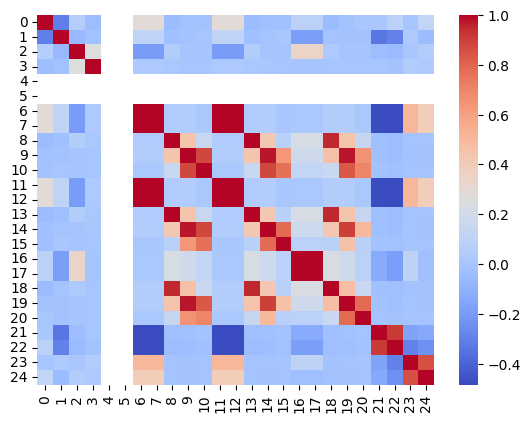

In [5]:
df = pd.DataFrame(benign_features + malicious_features)

corr_matrix = df.corr()
# print(df.describe())

sns.heatmap(corr_matrix, cmap='coolwarm')

In [7]:
print(f"no.of benign flows: {len(benign_features)}")
print(f"no.of malicious flows: {len(malicious_features)}")


no.of benign flows: 3058
no.of malicious flows: 279110


In [8]:
# split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(benign_features + malicious_features, [0]*len(benign_features) + [1]*len(malicious_features), test_size=0.2, random_state=42)
print(f"no.of train samples: {len(X_train)}")
print(f"no.of test samples: {len(X_test)}")



no.of train samples: 225734
no.of test samples: 56434


accuracy of RandomForestClassifier: 1.0
[[  642     0]
 [    0 55792]]




/home/mani/main_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy of LogisticRegression: 0.9965091965836198
[[  470   172]
 [   25 55767]]


accuracy of DecisionTreeClassifier: 0.9999645603714074
[[  641     1]
 [    1 55791]]


accuracy of GradientBoostingClassifier: 0.9998936811142219
[[  638     4]
 [    2 55790]]


accuracy of AdaBoostClassifier: 1.0
[[  642     0]
 [    0 55792]]


accuracy of GaussianNB: 0.9638515788354538
[[  491   151]
 [ 1889 53903]]




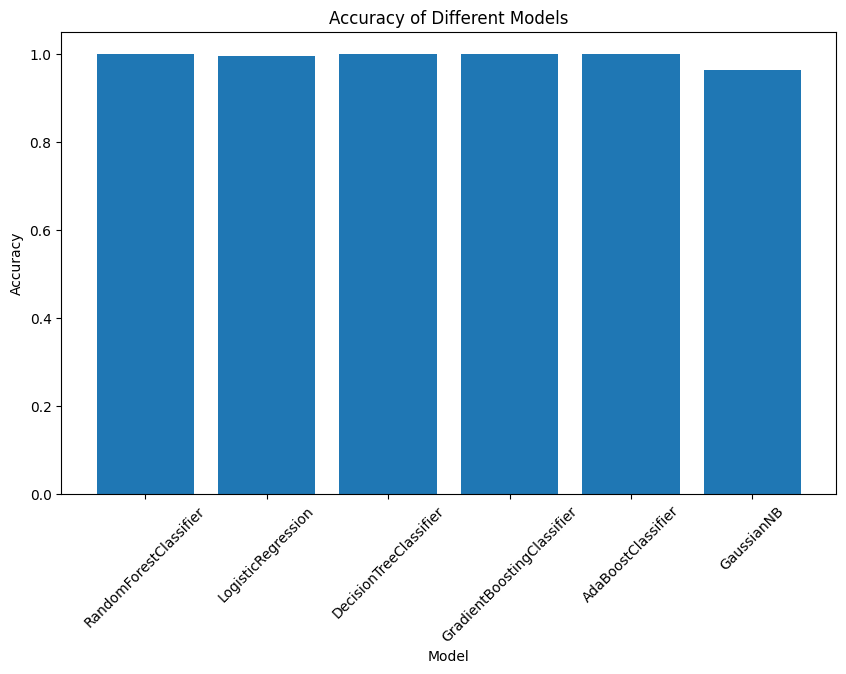

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

models = [
	RandomForestClassifier(n_estimators=100, random_state=42),
	LogisticRegression(),
	DecisionTreeClassifier(),
	GradientBoostingClassifier(),
	AdaBoostClassifier(),
	GaussianNB()
]

accuracies = []

for model in models:
	if isinstance(model, LogisticRegression):
		scaler = StandardScaler()
		X_train_scaled = scaler.fit_transform(X_train)
		X_test_scaled = scaler.transform(X_test)
		model.fit(X_train_scaled, y_train)
		y_pred = model.predict(X_test_scaled)
	else:
		model.fit(X_train, y_train)
		y_pred = model.predict(X_test)
	accuracy = accuracy_score(y_test, y_pred)
	accuracies.append(accuracy)
	
	print(f"accuracy of {model.__class__.__name__}: {accuracy_score(y_test, y_pred)}")
	print(confusion_matrix(y_test, y_pred))
	print("\n")
 
#  plot the accuracy of each model
model_names = [model.__class__.__name__ for model in models]
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45)
plt.show()

#  plot the relative plot for model accuracy
plt.figure(figsize=(10, 6))
plt.plot(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45)
plt.show()


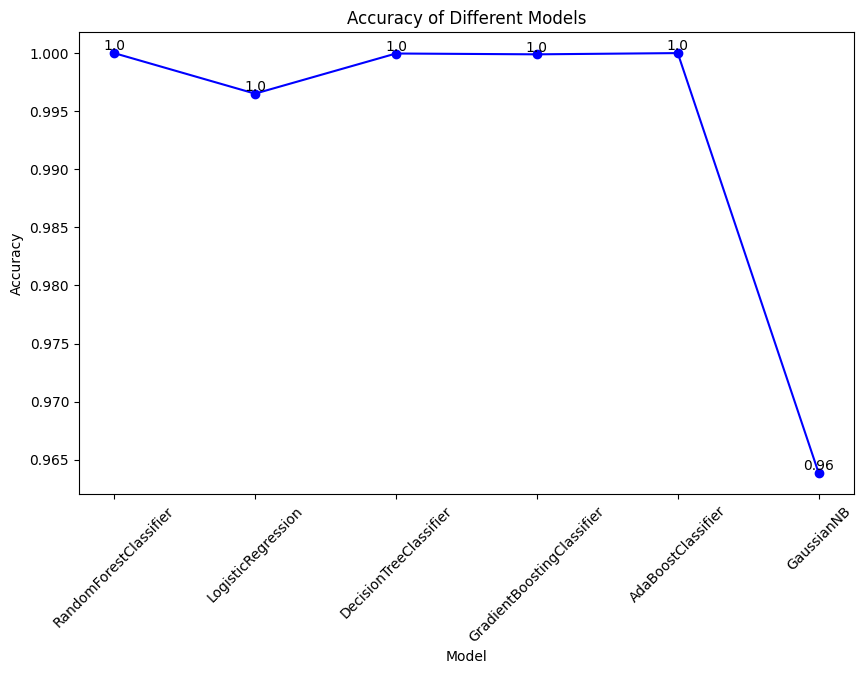

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(model_names, accuracies, marker='o', linestyle='-', color='blue')
for i, j in zip(model_names, accuracies):
	plt.text(i, j, str(round(j, 2)), ha='center', va='bottom', color='black')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45)
plt.show()

		        RF   							LR						DT     					GB      				Ada      				NB
Network packets  1   					0.9965091965836198		0.9999645603714074		0.9998936811142219				1				0.9638515788354538
PEfile 			0.9838056680161943       0.9190283400809717		0.9848178137651822		0.979757085020243		0.9352226720647774		0.8795546558704453